__Project 10: analysing the results of A/B test in a big online store__

_The goal of this project is to explore datasets, carry out analysis of the data and make recommendations about A/B testing._  

_To do this we'll:_  
* _preprocess the data identifying and filling in missing values, identifying and remove duplicate values,_  
* _graph:_  
    * _cumulative revenue by group,_  
    * _cumulative average order size by group,_  
    * _the relative difference in cumulative average order size for group B compared with group A,_  
    * _a scatter chart of the number of orders per user,_  
    * _a scatter chart of order prices,_  
    * _the daily conversion rates of the two groups,_  
* _calculate:_ 
    * _each group's conversion rate as the ratio of orders to the number of visits for each day,_  
    * _the 95th and 99th percentiles for the number of orders per user,_  
    * _the 95th and 99th percentiles of order prices,_  
* _find:_ 
    * _the statistical significance of the difference in conversion between the groups using the raw data,_  
    * _the statistical significance of the difference in average order size between the groups using the raw data,_  
    * _the statistical significance of the difference in conversion between the groups using the filtered data,_  
    * _the statistical significance of the difference in average order size between the groups using the filtered data,_  
* _make conclusions and conjectures._

In [1]:
# importing libraries: pandas, numpy, matplotlib, plotly.express, seaborn, proportions_ztest, shapiro, mannwhitneyu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [2]:
# loading dataframes
orders = pd.read_csv('orders_us.csv')
visits = pd.read_csv('visits_us.csv')

In [3]:
# saving raw data
orders_raw = orders
visits_raw = visits

In [4]:
# creating function to get info about dataframe
def get_info(df):
    display(df.head(10))
    df.info()

In [5]:
get_info(orders)
get_info(visits)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


__Checking for missing values__

In [6]:
# checking for missing values
print(orders.isna().sum())
print()
print(visits.isna().sum())

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

date      0
group     0
visits    0
dtype: int64


_No missing values_

__Checking for duplicates__

In [7]:
# checking for duplicated rows
print(orders.duplicated().sum())
print(visits.duplicated().sum())

0
0


_No duplicates_

__Preparing data in the dataframes__

In [8]:
# changing the types of the columns
orders['group'] = orders['group'].astype('category')
orders['transactionId'] = orders['transactionId'].astype('str')
orders['visitorId'] = orders['visitorId'].astype('str')
orders['date'] =  pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visits['date'] =  pd.to_datetime(visits['date'], format = '%Y-%m-%d')
visits['group'] = visits['group'].astype('category')

In [9]:
get_info(orders)
get_info(visits)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   object        
 1   visitorId      1197 non-null   object        
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 38.8+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [10]:
# finding visitorId which belongs both to A and B groups
orders_by_visitors = orders.groupby('visitorId', as_index = False).nunique()
orders_by_visitors_in_both_groups = orders_by_visitors[orders_by_visitors['group'] > 1]
orders_by_visitors_in_both_groups = orders_by_visitors_in_both_groups.drop(columns = ['transactionId', 'date', 'revenue', 'group'])
get_info(orders_by_visitors_in_both_groups)

,visitorId
57,1230306981
69,1294878855
75,1316129916
78,1333886533
102,1404934699
154,1602967004
161,1614305549
171,1648269707
175,1668030113
193,1738359350


<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, 57 to 1018
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   visitorId  58 non-null     object
dtypes: object(1)
memory usage: 928.0+ bytes


In [11]:
# removing visitorId which belongs both to A and B groups
orders = orders.merge(orders_by_visitors_in_both_groups, on = 'visitorId', how = 'left', indicator = True)
orders = orders[orders['_merge'] == 'left_only'].drop(columns = ['_merge'])
get_info(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B
10,3649131742,879864040,2019-08-15,65.7,A


<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   object        
 1   visitorId      1016 non-null   object        
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), object(2)
memory usage: 40.8+ KB


__A/B Test Analysis__

__1. Graph cumulative revenue by group. Make conclusions and conjectures.__

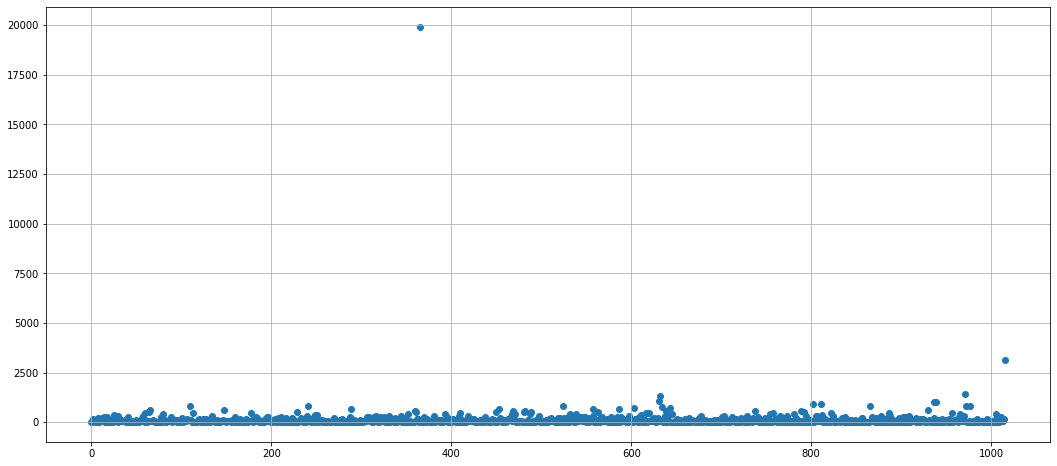

In [12]:
# creating plot to find outliers in orders['revenue']
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize = (18, 8))
plt.grid()
plt.scatter(x_values, orders['revenue']);

_We can see orders-outliers with unusually big revenue_

In [13]:
# finding values in orders['revenue'] with percentiles: 95, 97.5, 99, 99.9
print(np.percentile(orders['revenue'], [95, 97.5, 99, 99.9]))

[ 414.275   578.75    830.3    3094.6855]


In [14]:
# finding transaction-outliers with unusually big revenue
orders_sorted_by_revenue = orders.sort_values(by = ['revenue'], ascending = False)
display(orders_sorted_by_revenue)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,19920.4,B
1196,3936777065,2108080724,2019-08-15,3120.1,B
1136,666610489,1307669133,2019-08-13,1425.8,A
744,3668308183,888512513,2019-08-27,1335.6,B
743,3603576309,4133034833,2019-08-09,1050.0,A
...,...,...,...,...,...
414,2505918657,2524310328,2019-08-06,5.2,B
908,3352225027,1807547430,2019-08-05,5.2,B
404,2052514069,1995481842,2019-08-28,5.1,B
602,2356264591,1224903511,2019-08-09,5.1,A


_Transaction-outlier with unusually big revenue (above 99.9 percentile) are IDs: 590470918 and 3936777065_

In [15]:
# dropping transactions-outliers with unusually big revenue (above 99.9 percentile)
orders = orders.drop([425, 1196], axis = 0)

In [16]:
orders['date']

0      2019-08-15
1      2019-08-15
3      2019-08-15
4      2019-08-15
5      2019-08-15
          ...    
1190   2019-08-14
1191   2019-08-14
1192   2019-08-14
1193   2019-08-14
1194   2019-08-14
Name: date, Length: 1014, dtype: datetime64[ns]

In [17]:
# creating orders_A_group_cumulative_order and orders_B_group_cumulative_order containing cumulative revenue 
orders_A_group_cumulative_order = orders[orders['group'] == 'A'].groupby(['date'])['revenue'].sum().reset_index()
orders_A_group_cumulative_order['revenue_cumulative'] = orders_A_group_cumulative_order['revenue'].cumsum()
orders_B_group_cumulative_order = orders[orders['group'] == 'B'].groupby(['date'])['revenue'].sum().reset_index()
orders_B_group_cumulative_order['revenue_cumulative'] = orders_B_group_cumulative_order['revenue'].cumsum()

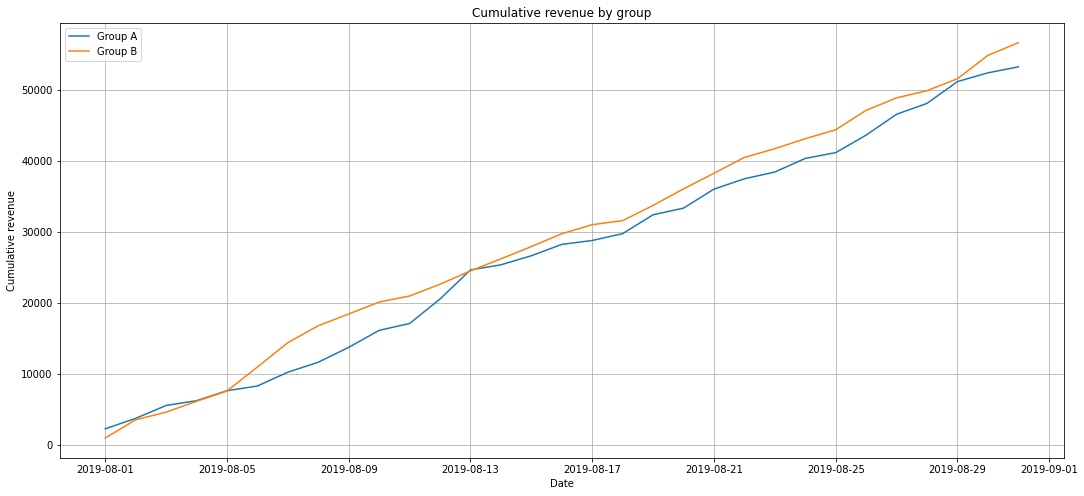

In [18]:
# creating plot with cumulative revenue by group
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_cumulative_order['date'], orders_A_group_cumulative_order['revenue_cumulative'], label = 'Group A')
plt.plot(orders_B_group_cumulative_order['date'], orders_B_group_cumulative_order['revenue_cumulative'], label = 'Group B')
plt.title('Cumulative revenue by group')
plt.xlabel('Date')
plt.ylabel('Cumulative revenue')
plt.grid()
plt.legend();

In [19]:
# creating orders_A_group_by_date and orders_B_group_by_date containing revenue in each group
orders_A_group_by_date = orders[orders['group'] == 'A'].groupby(['date'])['revenue'].sum()
orders_B_group_by_date = orders[orders['group'] == 'B'].groupby(['date'])['revenue'].sum()

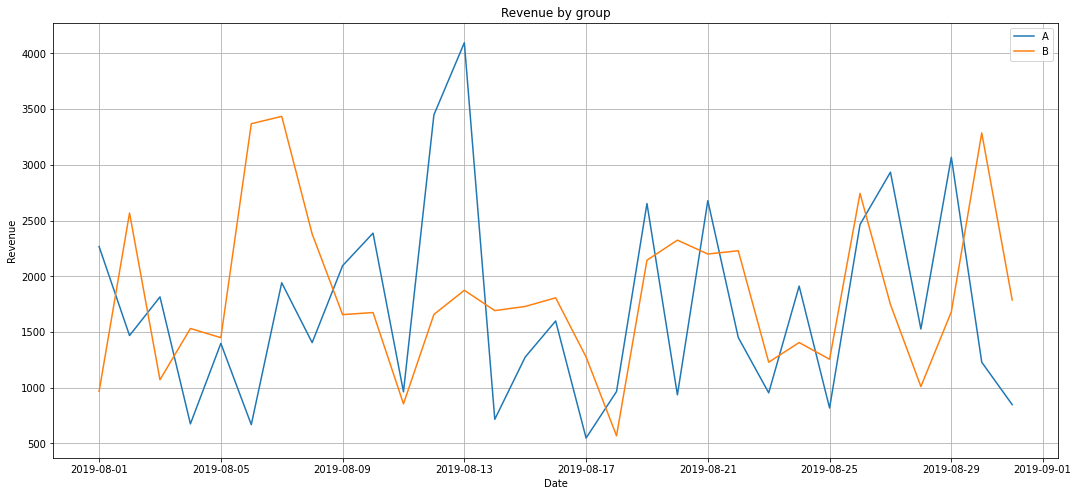

In [20]:
# creating plot with revenue by group
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_by_date, label = 'A')
plt.plot(orders_B_group_by_date, label = 'B')
plt.title('Revenue by group')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid()
plt.legend();

_Usually group B showing better result in cumulative revenue even without transactions-outliers.  
Revenue fluctuations in groups are similar._

__2. Graph cumulative average order size by group. Make conclusions and conjectures.__

In [21]:
# splitting order dataframe into two dataframes by group
orders_A_group = orders[orders['group'] == 'A']
orders_B_group = orders[orders['group'] == 'B']

In [22]:
# grouping dataframes by date, finding average order size, cumulative number of orders, cumulative revenue and cumulative average order size
orders_A_group_by_date = orders[orders['group'] == 'A'].groupby(['date']).agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_B_group_by_date = orders[orders['group'] == 'B'].groupby(['date']).agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_A_group_by_date['order_size_avg'] = orders_A_group_by_date['revenue'] / orders_A_group_by_date['transactionId']
orders_B_group_by_date['order_size_avg'] = orders_B_group_by_date['revenue'] / orders_B_group_by_date['transactionId']
orders_A_group_by_date['transactionId_cumul'] = orders_A_group_by_date['transactionId'].cumsum()
orders_B_group_by_date['transactionId_cumul'] = orders_B_group_by_date['transactionId'].cumsum()
orders_A_group_by_date['revenue_cumul'] = orders_A_group_by_date['revenue'].cumsum()
orders_B_group_by_date['revenue_cumul'] = orders_B_group_by_date['revenue'].cumsum()
orders_A_group_by_date['order_size_cumul'] = orders_A_group_by_date['revenue_cumul'] / orders_A_group_by_date['transactionId_cumul']
orders_B_group_by_date['order_size_cumul'] = orders_B_group_by_date['revenue_cumul'] / orders_B_group_by_date['transactionId_cumul']
get_info(orders_A_group_by_date)
get_info(orders_B_group_by_date)

,date,transactionId,revenue,order_size_avg,transactionId_cumul,revenue_cumul,order_size_cumul
0,2019-08-01,23,2266.6,98.547826,23,2266.6,98.547826
1,2019-08-02,19,1468.3,77.278947,42,3734.9,88.926190
2,2019-08-03,24,1815.2,75.633333,66,5550.1,84.092424
3,2019-08-04,11,675.5,61.409091,77,6225.6,80.851948
4,2019-08-05,22,1398.0,63.545455,99,7623.6,77.006061
5,2019-08-06,15,668.4,44.560000,114,8292.0,72.736842
6,2019-08-07,16,1942.0,121.375000,130,10234.0,78.723077
7,2019-08-08,14,1404.8,100.342857,144,11638.8,80.825000
8,2019-08-09,11,2095.2,190.472727,155,13734.0,88.606452
9,2019-08-10,15,2387.5,159.166667,170,16121.5,94.832353


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 31 non-null     datetime64[ns]
 1   transactionId        31 non-null     int64         
 2   revenue              31 non-null     float64       
 3   order_size_avg       31 non-null     float64       
 4   transactionId_cumul  31 non-null     int64         
 5   revenue_cumul        31 non-null     float64       
 6   order_size_cumul     31 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 1.8 KB


,date,transactionId,revenue,order_size_avg,transactionId_cumul,revenue_cumul,order_size_cumul
0,2019-08-01,17,967.2,56.894118,17,967.2,56.894118
1,2019-08-02,23,2568.1,111.656522,40,3535.3,88.382500
2,2019-08-03,14,1071.6,76.542857,54,4606.9,85.312963
3,2019-08-04,14,1531.6,109.400000,68,6138.5,90.272059
4,2019-08-05,21,1449.3,69.014286,89,7587.8,85.256180
5,2019-08-06,23,3369.3,146.491304,112,10957.1,97.831250
6,2019-08-07,23,3435.6,149.373913,135,14392.7,106.612593
7,2019-08-08,22,2379.9,108.177273,157,16772.6,106.831847
8,2019-08-09,19,1656.2,87.168421,176,18428.8,104.709091
9,2019-08-10,22,1674.8,76.127273,198,20103.6,101.533333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 31 non-null     datetime64[ns]
 1   transactionId        31 non-null     int64         
 2   revenue              31 non-null     float64       
 3   order_size_avg       31 non-null     float64       
 4   transactionId_cumul  31 non-null     int64         
 5   revenue_cumul        31 non-null     float64       
 6   order_size_cumul     31 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 1.8 KB


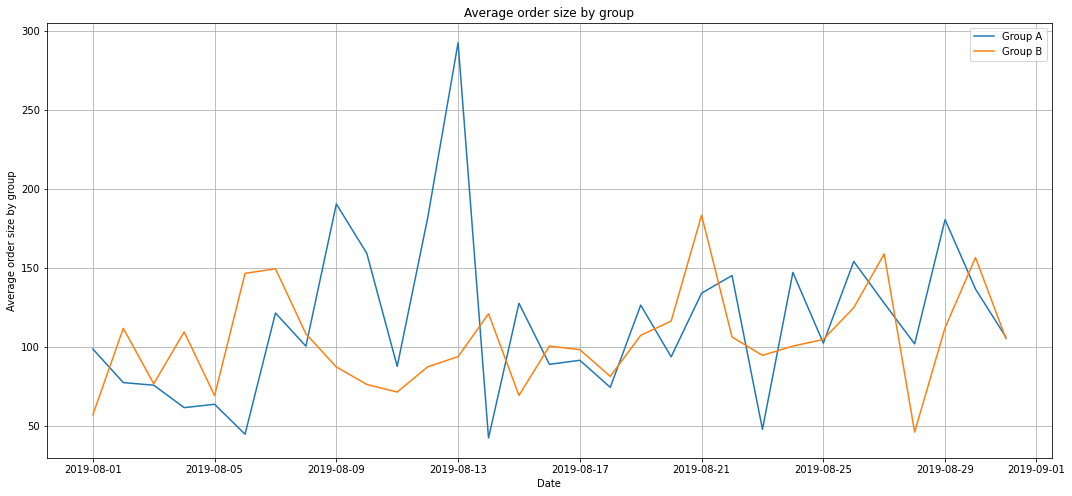

In [23]:
# creating plot with average order size by group
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_by_date['date'], orders_A_group_by_date['order_size_avg'], label = 'Group A')
plt.plot(orders_B_group_by_date['date'], orders_B_group_by_date['order_size_avg'], label = 'Group B')
plt.title('Average order size by group')
plt.xlabel('Date')
plt.ylabel('Average order size by group')
plt.grid()
plt.legend();

In [24]:
# finding the mean average order size in the group A
orders_A_group_by_date['order_size_avg'].mean()

115.5124717608274

In [25]:
# finding the mean average order size in the group B
orders_B_group_by_date['order_size_avg'].mean()

104.15091953581474

_There is little more fluctuations in group A.  
Average order size in the group A is bigger._

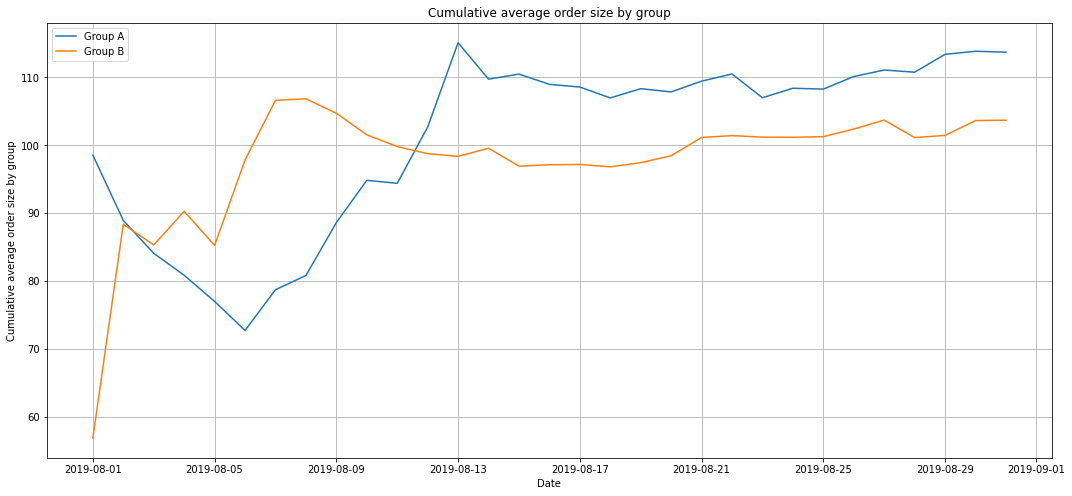

In [26]:
# creating plot with cumulative average order size by group
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_by_date['date'], orders_A_group_by_date['order_size_cumul'], label = 'Group A')
plt.plot(orders_B_group_by_date['date'], orders_B_group_by_date['order_size_cumul'], label = 'Group B')
plt.title('Cumulative average order size by group')
plt.xlabel('Date')
plt.ylabel('Cumulative average order size by group')
plt.grid()
plt.legend();

_Cumulative average order size after fluctuations in the group A is higher then in the group B.  
Cumulative average order size in both groups after 13.09.2019 are stable._

__3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.__

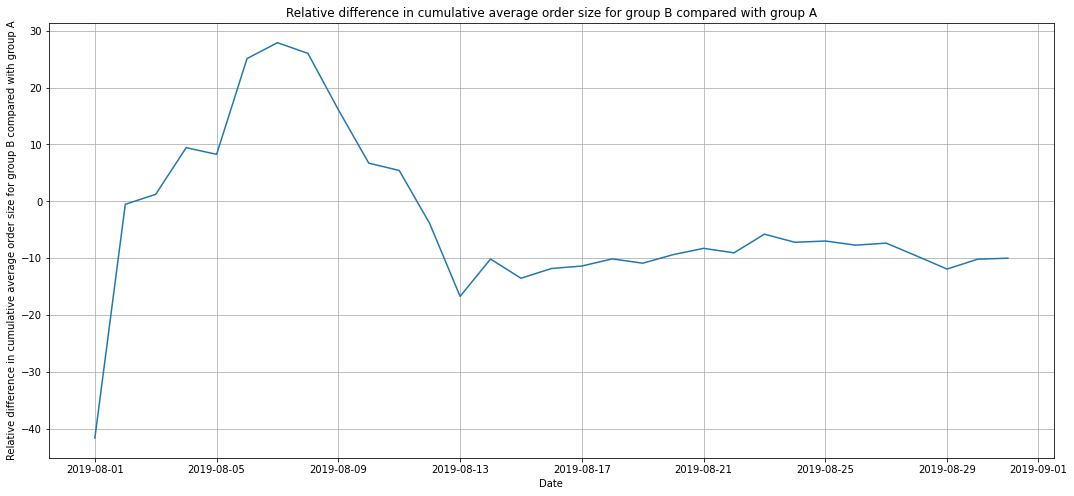

In [27]:
# creating plot with relative difference in cumulative average order size for group B compared with group A
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_by_date['date'], (orders_B_group_by_date['order_size_cumul'] - orders_A_group_by_date['order_size_cumul']))
plt.title('Relative difference in cumulative average order size for group B compared with group A')
plt.xlabel('Date')
plt.grid()
plt.ylabel('Relative difference in cumulative average order size for group B compared with group A');

_Cumulative average order size after fluctuations in the group A is higher then in the group B about 10.  
Considering that group B showing better result in cumulative revenue it can shows that number of orders in the group B are bigger._

__4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.__

In [28]:
# creating visits_A_group and visits_B_group containing visits by group 
visits_A_group = visits[visits['group'] == 'A'].groupby(['date'])['visits'].sum().reset_index()
visits_B_group = visits[visits['group'] == 'B'].groupby(['date'])['visits'].sum().reset_index()

In [29]:
# making orders_A_group_cumulative_order and orders_B_group_cumulative_order dataframes with merged raw data grouped by date
orders_A_group_cumulative_order = orders_A_group_by_date.merge(visits_A_group, on = 'date')
orders_B_group_cumulative_order = orders_B_group_by_date.merge(visits_B_group, on = 'date')

In [30]:
# calculating conversion rate
orders_A_group_cumulative_order['conversion_rate'] = orders_A_group_cumulative_order['transactionId'] / orders_A_group_cumulative_order['visits']
orders_B_group_cumulative_order['conversion_rate'] = orders_B_group_cumulative_order['transactionId'] / orders_B_group_cumulative_order['visits']

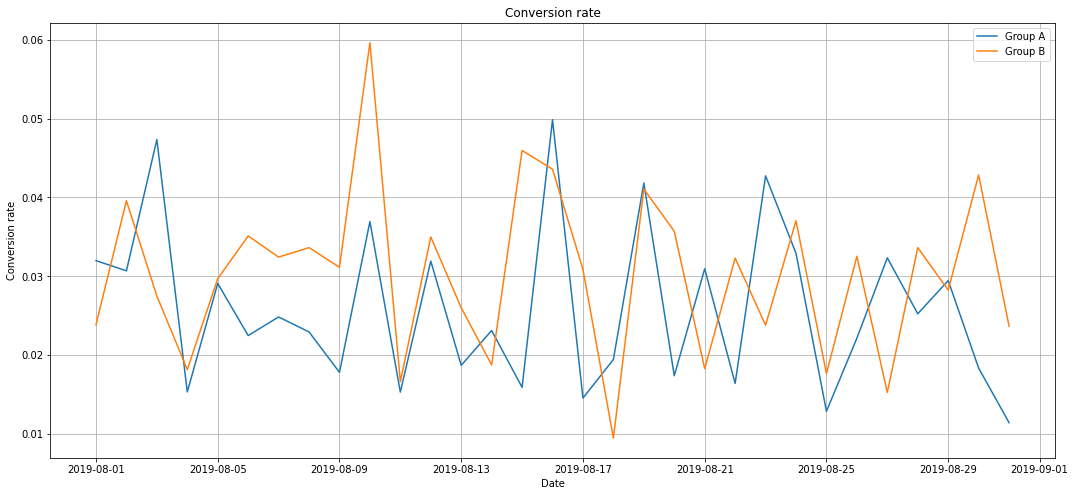

In [31]:
# creating plot with conversion rate
plt.figure(figsize = (18, 8))
plt.plot(orders_A_group_cumulative_order['date'], orders_A_group_cumulative_order['conversion_rate'], label = 'Group A')
plt.plot(orders_B_group_cumulative_order['date'], orders_B_group_cumulative_order['conversion_rate'], label = 'Group B')
plt.title('Conversion rate')
plt.xlabel('Date')
plt.ylabel('Conversion rate')
plt.grid()
plt.legend();

In [32]:
# finding the mean conversion in the group A
orders_A_group_cumulative_order['conversion_rate'].mean()

0.025890306958716493

In [33]:
# finding the mean conversion in the group B
orders_B_group_cumulative_order['conversion_rate'].mean()

0.030298466566994108

_There is little more fluctuations in the group B.  
Mean conversion in the group B is bigger._

__5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.__

In [34]:
# creating dataframes for both groups grouped by the number of users who created orders
orders_A_group_by_visitor = orders[orders['group'] == 'A'].groupby(['visitorId']).nunique().reset_index()
orders_B_group_by_visitor = orders[orders['group'] == 'B'].groupby(['visitorId']).nunique().reset_index()

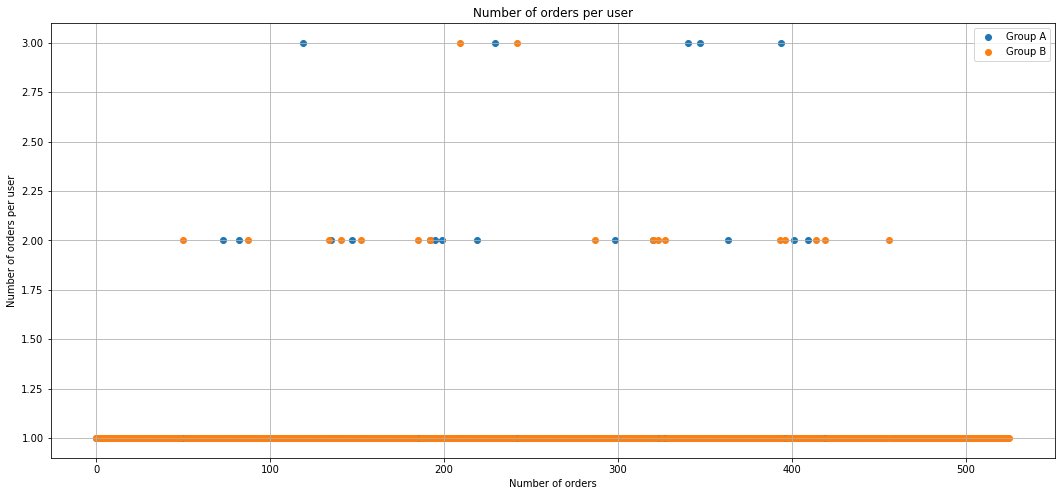

In [35]:
# creating scatterplot 
x_values_A = pd.Series(range(0, len(orders_A_group_by_visitor['transactionId'])))
x_values_B = pd.Series(range(0, len(orders_B_group_by_visitor['transactionId'])))
plt.figure(figsize = (18, 8))
plt.scatter(x_values_A, orders_A_group_by_visitor['transactionId'], label = 'Group A')
plt.scatter(x_values_B, orders_B_group_by_visitor['transactionId'], label = 'Group B');
plt.title('Number of orders per user')
plt.xlabel('Number of orders')
plt.ylabel('Number of orders per user')
plt.grid()
plt.legend();

In [36]:
# finding number of orders by user in the A group
orders_A_group_by_visitor['transactionId'].value_counts()

transactionId
1    427
2     13
3      5
Name: count, dtype: int64

In [37]:
# finding number of orders by user in the B group
orders_B_group_by_visitor['transactionId'].value_counts()

transactionId
1    508
2     16
3      2
Name: count, dtype: int64

_Most of the users in the both groups make one order. No users who made more than 3 orders._

__6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.__

In [38]:
# finding values in orders_A_group_by_visitor['transactionId'] with percentiles: 95, 99
print(np.percentile(orders_A_group_by_visitor['transactionId'], [95, 99]))

[1.   2.56]


In [39]:
# finding values in orders_B_group_by_visitor['transactionId'] with percentiles: 95, 99
print(np.percentile(orders_B_group_by_visitor['transactionId'], [95, 99]))

[1. 2.]


_There is no anomalies in the data. We dropped anomallies before._

__7. Plot a scatter chart of order prices. Make conclusions and conjectures.__

In [40]:
# creating orders_A_group and orders_B_group containing revenue in each group
orders_A_group = orders[orders['group'] == 'A']
orders_B_group = orders[orders['group'] == 'B']

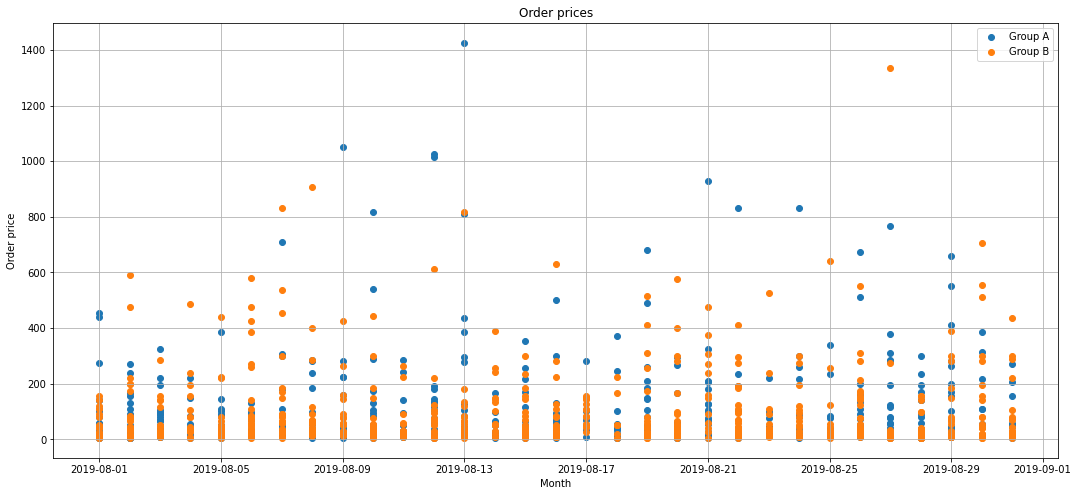

In [41]:
# creating scatterplot
plt.figure(figsize = (18, 8))
plt.scatter(orders_A_group['date'], orders_A_group['revenue'], label = 'Group A')
plt.scatter(orders_B_group['date'], orders_B_group['revenue'], label = 'Group B')
plt.title('Order prices')
plt.xlabel('Month')
plt.ylabel('Order price')
plt.grid()
plt.legend();

In [42]:
orders_A_group['revenue'].describe()

count     468.000000
mean      113.700855
std       171.372117
min         5.000000
25%        20.300000
50%        50.100000
75%       131.925000
max      1425.800000
Name: revenue, dtype: float64

In [43]:
orders_B_group['revenue'].describe()

count     546.000000
mean      103.682601
std       145.198308
min         5.100000
25%        20.800000
50%        45.800000
75%       123.825000
max      1335.600000
Name: revenue, dtype: float64

_Mean and median revenue in the B group is bigger._

__8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.__

In [44]:
# finding values in orders['revenue'] with percentiles: 95, 99
print(np.percentile(orders['revenue'], [95, 99]))

[410.5 815.8]


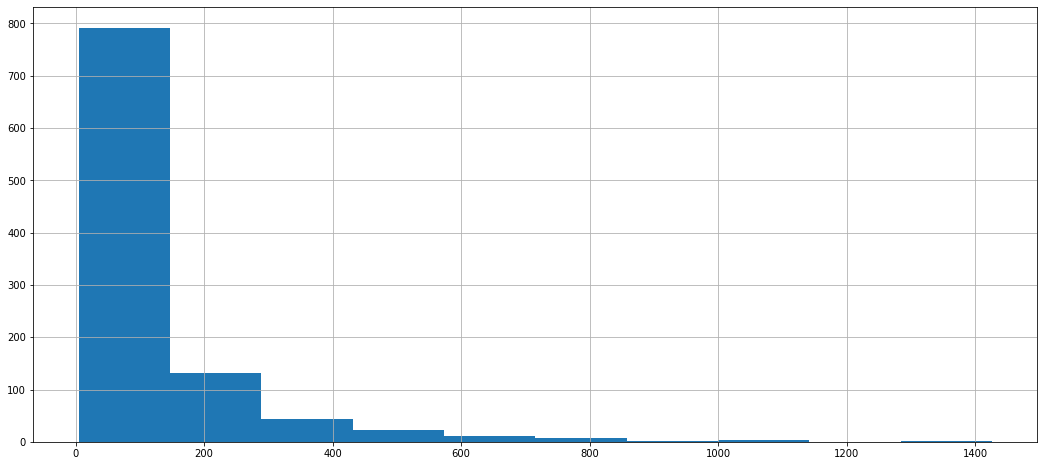

In [45]:
# plotting histogram
plt.figure(figsize = (18, 8))
plt.grid()
plt.hist(orders['revenue']);

_There is no anomalies in the data. We dropped anomallies before._

__9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.__

_H0: No difference between conversion in the groups in the raw data._

In [46]:
orders_raw

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [47]:
# making orders_raw_A_group and orders_raw_B_group dataframes with merged raw data grouped by date
visits_raw_A_group = visits_raw[visits_raw['group'] == 'A'].groupby(['date'])['visits'].sum().reset_index()
visits_raw_B_group = visits_raw[visits_raw['group'] == 'B'].groupby(['date'])['visits'].sum().reset_index()
orders_raw_A_group = orders_raw[orders_raw['group'] == 'A'].groupby(['date']).agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_raw_B_group = orders_raw[orders_raw['group'] == 'B'].groupby(['date']).agg({'transactionId': 'nunique', 'revenue': 'sum'}).reset_index()
orders_raw_A_group = orders_raw_A_group.merge(visits_raw_A_group, on = 'date')
orders_raw_B_group = orders_raw_B_group.merge(visits_raw_B_group, on = 'date')

In [48]:
# finding statistical significance of the difference in conversion
z_stat, p_value = proportions_ztest([orders_raw_A_group['transactionId'].sum(), orders_raw_B_group['transactionId'].sum()], [orders_raw_A_group['visits'].sum(), orders_raw_B_group['visits'].sum()])
print('Statistical significance of the difference in conversion:', p_value)

Statistical significance of the difference in conversion: 0.02320723394441847


_Statistical significance of the difference in conversion between the groups in the raw data is low (below 0.05).  
H0 rejected._

__10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.__

_H0: No difference between average order size in the groups in the raw data._

In [49]:
# calculating average order sizes in the raw data
orders_raw_A_group['order_size_avg'] = orders_raw_A_group['revenue'] / orders_raw_A_group['transactionId']
orders_raw_B_group['order_size_avg'] = orders_raw_B_group['revenue'] / orders_raw_B_group['transactionId']

In [50]:
# checking if disributions of average order sizes in the raw data are normal
print(shapiro(orders_raw_A_group['order_size_avg']))
print(shapiro(orders_raw_B_group['order_size_avg']))

ShapiroResult(statistic=0.878296971321106, pvalue=0.0021608269307762384)
ShapiroResult(statistic=0.3308287262916565, pvalue=8.560252506839561e-11)


_Both distributions of average order sizes in the raw data are not normal. We should use Mann–Whitney U test._

In [51]:
print(mannwhitneyu(orders_raw_A_group['order_size_avg'], orders_raw_B_group['order_size_avg']))

MannwhitneyuResult(statistic=423.0, pvalue=0.4222761086468382)


_Statistical significance of the difference in average order size between the groups using the raw data is high (above 0.05).  
Fail to reject H0._

__11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.__

_H0: No difference between conversion in the groups in the filtered data._

In [52]:
# finding statistical significance of the difference in conversion
z_stat, p_value = proportions_ztest([orders_A_group_cumulative_order['transactionId'].sum(), orders_B_group_cumulative_order['transactionId'].sum()], [orders_A_group_cumulative_order['visits'].sum(), orders_B_group_cumulative_order['visits'].sum()])
print('Statistical significance of the difference in conversion:', p_value)

Statistical significance of the difference in conversion: 0.01986659212118497


_Statistical significance of the difference in conversion between the groups is low (below 0.05).  
H0 rejected._

__12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.__

_H0: No difference between average order size in the groups in the filtered data._

In [53]:
# calculating average order sizes
orders_A_group_cumulative_order['order_size_avg'] = orders_A_group_cumulative_order['revenue'] / orders_A_group_cumulative_order['transactionId']
orders_B_group_cumulative_order['order_size_avg'] = orders_B_group_cumulative_order['revenue'] / orders_B_group_cumulative_order['transactionId']

In [54]:
# checking if disributions of average order sizes are normal
print(shapiro(orders_A_group_cumulative_order['order_size_avg']))
print(shapiro(orders_B_group_cumulative_order['order_size_avg']))

ShapiroResult(statistic=0.9144196510314941, pvalue=0.01683112233877182)
ShapiroResult(statistic=0.9621258974075317, pvalue=0.33174824714660645)


_Distribution of average order sizes in the group A is normal, in the group B - is not normal. We should use Mann–Whitney U test._

In [55]:
print(mannwhitneyu(orders_A_group_cumulative_order['order_size_avg'], orders_B_group_cumulative_order['order_size_avg']))

MannwhitneyuResult(statistic=523.0, pvalue=0.5543193695171094)


_Statistical significance of the difference in average order size between the groups is high (above 0.05).  
Fail to reject H0._

__13. Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.__

___Conclusions___  
_1. Usually group B showing better result in cumulative revenue even without transactions-outliers. Revenue fluctuations in groups are similar._  
_2. Average order size in the group A is bigger._  
_3. Cumulative average order size after fluctuations in the group A is higher then in the group B about 10._  
_4. Mean conversion in the group B is bigger._  
_5. Most of the users in the both groups make one order. No users who made more than 3 orders._  
_6. Mean and median revenue in the B group is bigger._  
_7. Statistical significance of the difference in conversion between the groups in the raw data is low (below 0.05). H0 rejected._  
_8. Statistical significance of the difference in average order size between the groups in the raw data is high (above 0.05). Fail to reject H0._  
_9. Statistical significance of the difference in conversion between the groups in the filtered data is low (below 0.05). H0 rejected._  
_10. Statistical significance of the difference in average order size between the groups in the filtered is high (above 0.05). Fail to reject H0._  
_11. We can't say with certainty if the hypothesis that the conversion in one of the group is bigger because of rejecting the H0._  
_12. There is high probability that average order size in the group A is higher because of failing to reject the H0._  
_13. It's recommended to stop the test, consider the group B as the leader. The relative difference in cumulative average order size for group B compared with group A is stable and statistical significance of the difference is high (above 0.05), we can say that the difference is significant_